In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, uniform, expon

1. Прочитайте данные из файлов train.npz и test.npz Каждый файл содержит 2 массива - samples(данные) и answers(класс).
samples $_i \in R$, answers $_i \in\{0,1,2\}$

In [ ]:
test = np.load('Фамилимя_test.npz')
train = np.load('Фамилия_train.npz')

In [ ]:
samples = train['samples']
answers = train['answers']

2. Выделите данные, соответствующие каждому классу $0,1,2$ на обучающей выборке

In [ ]:
class_0 = []
class_1 = []
class_2 = []

for i in range(len(answers)):
    if answers[i] == 0:
        class_0.append(samples[i])
    elif answers[i] == 1:
        class_1.append(samples[i])
    elif answers[i] == 2:
        class_2.append(samples[i])

In [ ]:
class_0 = np.array(class_0)
class_1 = np.array(class_1)
class_2 = np.array(class_2)

In [ ]:
print('Class 0: ', class_0.shape)
print('Class 1: ', class_1.shape)
print('Class 2: ', class_2.shape)

Class 0:  (1000,)
Class 1:  (1500,)
Class 2:  (500,)


3. Визуализируйте выборку для каждого класса и сделайте предположение о виде функции распредления

In [ ]:
def visualize_samples(class_0, class_1, class_2):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].hist(class_0, bins=30, density=True)
    axs[0].set_title('Class 0')
    axs[1].hist(class_1, bins=30, density=True)
    axs[1].set_title('Class 1')
    axs[2].hist(class_2, bins=30, density=True)
    axs[2].set_title('Class 2')
    plt.show()

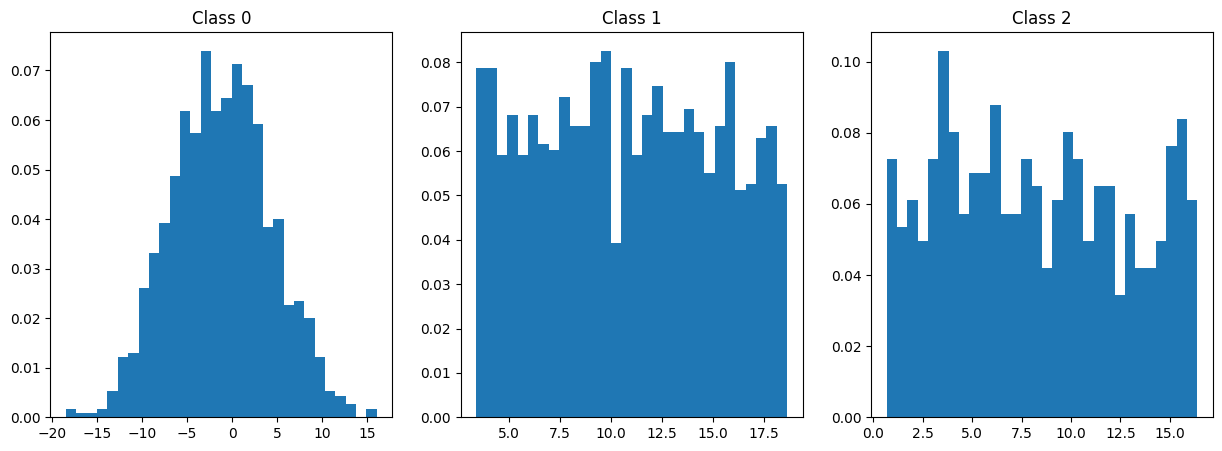

In [ ]:
visualize_samples(class_0, class_1, class_2)

4. Сделайте состоятельные точечные оценки параметров распределений. (Видов распределений вам может встретиться всего 3 - равномерное, нормальное и экспоненциальное. Для равномерного $U(a, b)$ распределения сделать оценки а и b, для нормального $N\left(\mu, \sigma^2\right)$ оценки $\mu$ и $\sigma^2$, для экспоненциального $\operatorname{Exp}(\lambda)$ оценку $\lambda$ )

In [ ]:
def params_class0(sample):
    mu = np.mean(sample)
    std = np.std(sample)
    return 'norm', mu, std

def params_class1(sample):
    a = min(sample)
    b = max(sample)
    return 'uniform', a, b-a

def params_class2(sample):
    lam = 1 / np.mean(sample)
    return 'expon', 1/lam

In [ ]:
class_0_params = params_class0(class_0)
class_1_params = params_class1(class_1)
class_2_params = params_class1(class_2)

5. Постройте графики распределений для исходной выборки и для выборки сгенерированной с параметрами, найденными с помощью точечных оценок

In [ ]:
def plot_distributions(sample, params):
    dist_name = params[0]
    params = params[1:]
    fig, ax = plt.subplots(figsize=(8, 6))
    x = np.linspace(min(sample), max(sample), 1000)
    if dist_name == 'norm':
        mu, sigma = params
        pdf = norm.pdf(x, loc=mu, scale=sigma)
    elif dist_name == 'uniform':
        a, b = params
        pdf = uniform.pdf(x, loc=a, scale=b)
    elif dist_name == 'expon':
        lam = params
        pdf = expon.pdf(x, scale=lam)
    ax.hist(sample, bins=30, density=True, alpha=0.5, label='Sample')
    ax.plot(x, pdf, 'r-', lw=2, label='Estimated Distribution')
    ax.set_title(f'{dist_name} Distribution')
    ax.legend()
    plt.show()

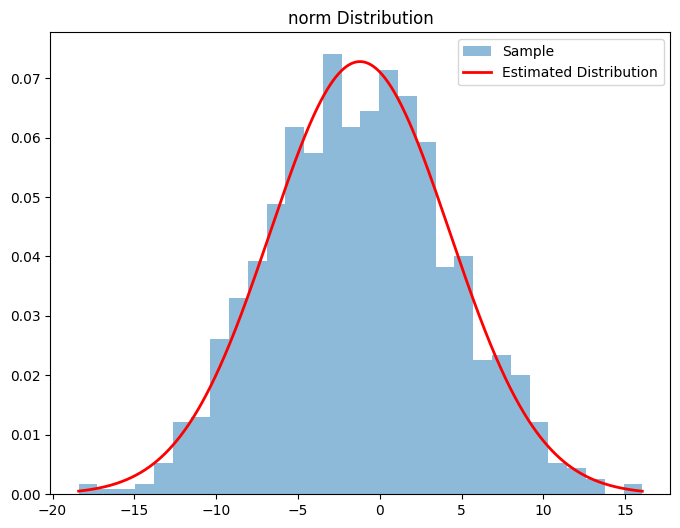

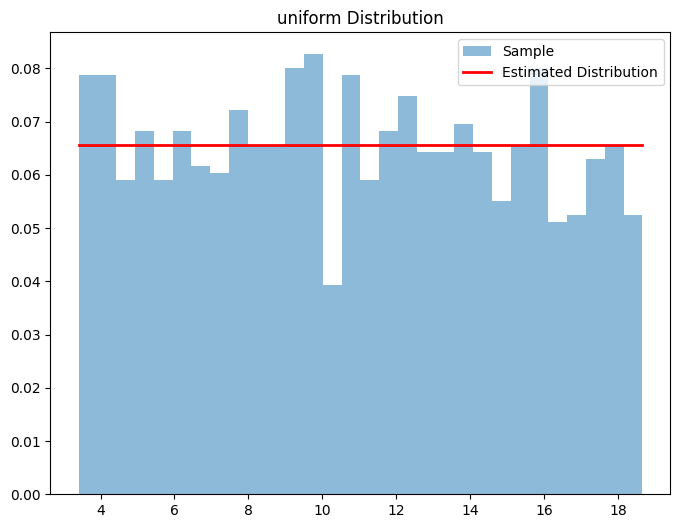

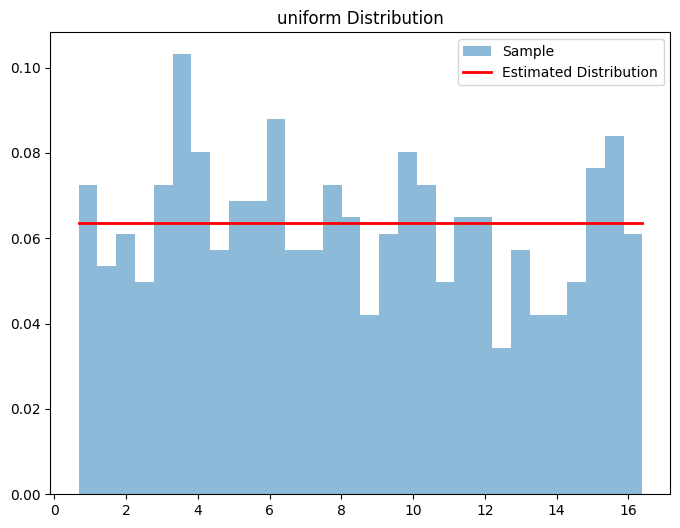

In [ ]:
plot_distributions(class_0, class_0_params)
plot_distributions(class_1, class_1_params)
plot_distributions(class_2, class_2_params)

6. Посчитайте статистику критерия Колмогорова для проверки гипотезы о том, что исходные данные являются реализацией случайной величины с функцией распределения, полученной по точечным оценкам

Пусть $D_n=\sup _{-\infty<x<\infty}\left|\hat{F}_n(x)-F(x)\right|$ где $\hat{F}_n(x)=\frac{1}{n} \sum_{i=1}^n I_{\left\{X_i \leq x\right\}}$ - это эмпирическая функция распределения, $F(x)$ функция распределения полученная с помощью оценок.

Посчитайте $\sqrt{N} * D_N$, где $N$ - число элементов выборки для каждой из выборок $1,2,3$

In [ ]:
def kolmogorov_test(sample, params):
    dist_name = params[0]
    params = params[1:]
    n = len(sample)
    sorted_sample = np.sort(sample)
    empirical_cdf = np.arange(1, n+1) / n

    if dist_name == 'norm':
        mu, sigma = params
        cdf = lambda x: norm.cdf(x, loc=mu, scale=sigma)
    elif dist_name == 'uniform':
        a, b = params
        cdf = lambda x: uniform.cdf(x, loc=a, scale=b)
    elif dist_name == 'expon':
        lam = params
        cdf = lambda x: expon.cdf(x, scale=lam)

    cdf_values = cdf(sorted_sample)
    D_n = np.max(np.abs(empirical_cdf - cdf_values))

    return np.sqrt(n) * D_n

In [ ]:
D_0 = kolmogorov_test(class_0, class_0_params)
D_1 = kolmogorov_test(class_1, class_1_params)
D_2 = kolmogorov_test(class_2, class_2_params)

In [ ]:
print(f'Class 0: D = {D_0:.4f}')
print(f'Class 1: D = {D_1:.4f}')
print(f'Class 2: D = {D_2:.4f}')

Class 0: D = 0.5755
Class 1: D = 1.0315
Class 2: D = 0.9926


7. На основе посчитанных параметров распределения постройте байесовский классификатор

In [ ]:
def classification_bayes(sample, class_0_params, class_1_params, class_2_params):
    dist_0, *param_0 = class_0_params
    dist_1, *param_1 = class_1_params
    dist_2, *param_2 = class_2_params

    # Get the probability density function (PDF) for each distribution
    dist_0_pdf = getattr(stats, dist_0).pdf
    dist_1_pdf = getattr(stats, dist_1).pdf
    dist_2_pdf = getattr(stats, dist_2).pdf

    # Calculate the probabilities for each class
    p_class_0 = dist_0_pdf(sample, *param_0)
    p_class_1 = dist_1_pdf(sample, *param_1)
    p_class_2 = dist_2_pdf(sample, *param_2)

    max_prob = max(p_class_0, p_class_1, p_class_2)
    if max_prob == p_class_0:
        return 0
    elif max_prob == p_class_1:
        return 1
    else:
        return 2

In [ ]:
samplesTest = test['samples']
answersTest = test['answers']

8. Для каждого класса на тестовой выборке посчитайте количество True Positive, False Positive $и$ False Negative.

In [ ]:
def errors(sample, correct_answer, cl):
    tp, fp, fn = 0, 0, 0
    for i in range(len(sample)):
        predicted = classification_bayes(sample[i], class_0_params, class_1_params, class_2_params)
        if predicted == cl:
            if correct_answer[i] == cl:
                tp += 1
            else:
                fp += 1
        else:
            if correct_answer[i] == cl:
                fn += 1
    return tp, fp, fn

In [ ]:
for i in range(3):
    tp, fp, fn = errors(samplesTest, answersTest, i)
    print(f'Class {i} - TP: {tp}, FP: {fp}, FN: {fn}')

Class 0 - TP: 71, FP: 6, FN: 29
Class 1 - TP: 100, FP: 101, FN: 0
Class 2 - TP: 12, FP: 10, FN: 88
